<a href="https://colab.research.google.com/github/shubhang239/Portfolio/blob/main/Covid_19_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Libraries


In [ ]:
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10,12
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [ ]:
# Reading the dataset
df1 = pd.read_csv('/content/COVID-19 Cases(19-11-2021).csv')
df = df1.copy()
df.head(8)

,S. No.,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
0,1,01/01/1970,India,34260470,161555.0,33641175.0,457740.0
1,2,12/03/2020,India,74,71.0,3.0,0.0
2,3,13/03/2020,India,75,71.0,3.0,1.0
3,4,14/03/2020,India,84,72.0,10.0,2.0
4,5,15/03/2020,India,107,95.0,10.0,2.0
5,6,16/03/2020,India,114,99.0,13.0,2.0
6,7,17/03/2020,India,137,120.0,14.0,3.0
7,8,18/03/2020,India,146,129.0,14.0,3.0


Under region there is India. Why is India under regions when this was supposed to be state data ? Will do a further analysis on this. Also I will find out the shape of our data and the datatypes present in it.


In [ ]:
df.shape

(22305, 7)

In [ ]:
df.columns

Index(['S. No.', 'Date', 'Region', 'Confirmed Cases', 'Active Cases',
       'Cured/Discharged', 'Death'],
      dtype='object')

In [ ]:
# try to understand each column
# drop s.no
df.drop(columns = ['S. No.'], axis = 1, inplace = True)

In [ ]:
df.dtypes

Date                 object
Region               object
Confirmed Cases       int64
Active Cases        float64
Cured/Discharged    float64
Death               float64
dtype: object

In [ ]:
df[df['Region'] == 'India'].shape

(600, 6)

We can infer that Region = India gives us the sum of cases of all states ie national count of cases with time. 
I want to check whether each state has cases measured for the same time period.
I will check the number of rows for each state's cases to verify this.

In [ ]:
print('For Rajasthan:', df[df['Region'] == 'Rajasthan'].shape)
print('For Meghalaya:', df[df['Region'] == 'Meghalaya'].shape)


For Rajasthan: (600, 6)
For Meghalaya: (566, 6)


It was same for Rajasthan and the national figure but different from Meghalaya. So its not necessary that cases have been measured for same dates.

## Data Cleaning
### Null Values Imputation

In [ ]:
df.isnull().sum()

Date                  0
Region                0
Confirmed Cases       0
Active Cases        609
Cured/Discharged    610
Death                 1
dtype: int64

In [ ]:
# look deeper into null values
df[df['Active Cases'].isnull()]

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
21696,01/01/1970,World,245373039,NaN,NaN,4979421.0
21697,12/03/2020,World,129149,NaN,NaN,4724.0
21698,13/03/2020,World,138704,NaN,NaN,5085.0
21699,14/03/2020,World,149469,NaN,NaN,5553.0
21700,15/03/2020,World,161291,NaN,NaN,6003.0
...,...,...,...,...,...,...
22300,08/11/2021,World,249743428,NaN,NaN,5047652.0
22301,10/11/2021,World,250715502,NaN,NaN,5062106.0
22302,11/11/2021,World,251266207,NaN,NaN,5070244.0
22303,12/11/2021,World,251788329,NaN,NaN,5077907.0


In [ ]:
df[df['Region'] == 'World'].shape

(609, 6)

In [ ]:
df_active_null = df[df.isnull()]
df_active_null['Region'].nunique()

0

All null values for active cases come from world count of cases. Instead of dropping we will just leave out these rows while selecting our new dataframe.

In [ ]:
df[df['Cured/Discharged'].isnull()]

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
18065,03/04/2020,State assignment pending,18,18.0,NaN,NaN
21696,01/01/1970,World,245373039,NaN,NaN,4979421.0
21697,12/03/2020,World,129149,NaN,NaN,4724.0
21698,13/03/2020,World,138704,NaN,NaN,5085.0
21699,14/03/2020,World,149469,NaN,NaN,5553.0
...,...,...,...,...,...,...
22300,08/11/2021,World,249743428,NaN,NaN,5047652.0
22301,10/11/2021,World,250715502,NaN,NaN,5062106.0
22302,11/11/2021,World,251266207,NaN,NaN,5070244.0
22303,12/11/2021,World,251788329,NaN,NaN,5077907.0


In [ ]:
df_discharged_null = df[df['Cured/Discharged'].isnull()] 
df_discharged_null['Region'].value_counts()

World                       609
State assignment pending      1
Name: Region, dtype: int64

In [ ]:
# convert the date column to datetime object
df['Date_converted'] = pd.to_datetime(df.Date, dayfirst = True)

In [ ]:
df['Date_converted'].dtype

dtype('<M8[ns]')

### Coverting String Date to Datetime format

In [ ]:
df['year'] = pd.DatetimeIndex(df['Date_converted']).year
df['month'] = pd.DatetimeIndex(df['Date_converted']).month

In [ ]:
df.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01/01/1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1
1,12/03/2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13/03/2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14/03/2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15/03/2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3


I will divide my dataframe into three parts, one only with states, one for the entire country and one for the world. So now I have three different dataframes for three different analysis

### Dividing Dataset into 3 separate Data Frames

In [ ]:
df_states = df[(df['Region'] != 'India') & (df['Region'] != 'World')]
df_india = df[df['Region'] == 'India']
df_world = df[df['Region'] == 'World']

### State Covid Data 

In [ ]:
df_states

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01/01/1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
601,27/03/2020,Andaman and Nicobar Islands,1,1.0,0.0,0.0,2020-03-27,2020,3
602,28/03/2020,Andaman and Nicobar Islands,6,6.0,0.0,0.0,2020-03-28,2020,3
603,29/03/2020,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020-03-29,2020,3
604,30/03/2020,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020-03-30,2020,3
...,...,...,...,...,...,...,...,...,...
21691,12/11/2021,West Bengal,1601586,7973.0,1574333.0,19280.0,2021-11-12,2021,11
21692,14/11/2021,West Bengal,1603318,8031.0,1575980.0,19307.0,2021-11-14,2021,11
21693,15/11/2021,West Bengal,1604193,8062.0,1576817.0,19314.0,2021-11-15,2021,11
21694,16/11/2021,West Bengal,1604975,8047.0,1577609.0,19319.0,2021-11-16,2021,11


In [ ]:
# the date 1/1/1970 in the rows could represent the sum we need of total cases for each state, we need to verify that
df_states[df_states['Date_converted'] == '1970-01-01'].head()


,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01/01/1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1185,01/01/1970,Andhra Pradesh,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
1785,01/01/1970,Arunachal Pradesh,55143,108.0,54755.0,280.0,1970-01-01,1970,1
2363,01/01/1970,Assam,610150,3791.0,600367.0,5992.0,1970-01-01,1970,1
2942,01/01/1970,Bihar,726085,45.0,716379.0,9661.0,1970-01-01,1970,1


In [ ]:
df_state_tot = df_states[df_states['Date_converted'] == '1970-01-01']
df_state_tot.rename(columns = {'Region': 'Name of State / UT'}, inplace = True)
df_state_tot.head()

,Date,Name of State / UT,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01/01/1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1185,01/01/1970,Andhra Pradesh,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
1785,01/01/1970,Arunachal Pradesh,55143,108.0,54755.0,280.0,1970-01-01,1970,1
2363,01/01/1970,Assam,610150,3791.0,600367.0,5992.0,1970-01-01,1970,1
2942,01/01/1970,Bihar,726085,45.0,716379.0,9661.0,1970-01-01,1970,1


Upon comparing with the actual data i figured out these are the cumulative values over the time period from which the data was taken uptill 25 September 2021.

**Data Visualization**

## Visualizing Total Covid Cases on the Map of India

In [ ]:
#@title
# coordinates of India states and union territories
india_coord = pd.read_excel('/content/Indian Coordinates.xlsx')

In [ ]:
#@title
df_full = pd.merge(india_coord, df_state_tot, on = 'Name of State / UT')
map = folium.Map(location = [20,70], zoom_start=4, tiles = 'Stamenterrain')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Confirmed Cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon], radius = value/100000, color = 'crimson', fill_color='red', ).add_to(map)

map

In [ ]:
#@title
df_full.shape

(15, 11)

In [ ]:
#@title
df_full.head()

,Name of State / UT,Latitude,Longitude,Date,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,Andaman and Nicobar Islands,11.667026,92.735983,01/01/1970,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1,Andhra Pradesh,14.750429,78.570026,01/01/1970,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
2,Dadra and Nagar Haveli and Daman and Diu,20.266578,73.016618,01/01/1970,10682,6.0,10672.0,4.0,1970-01-01,1970,1
3,Delhi,28.669993,77.230004,01/01/1970,1439788,334.0,1414363.0,25091.0,1970-01-01,1970,1
4,Gujarat,22.258700,71.192400,01/01/1970,826526,192.0,816246.0,10088.0,1970-01-01,1970,1


## Statewise Confirmed Vs Recovered Cases

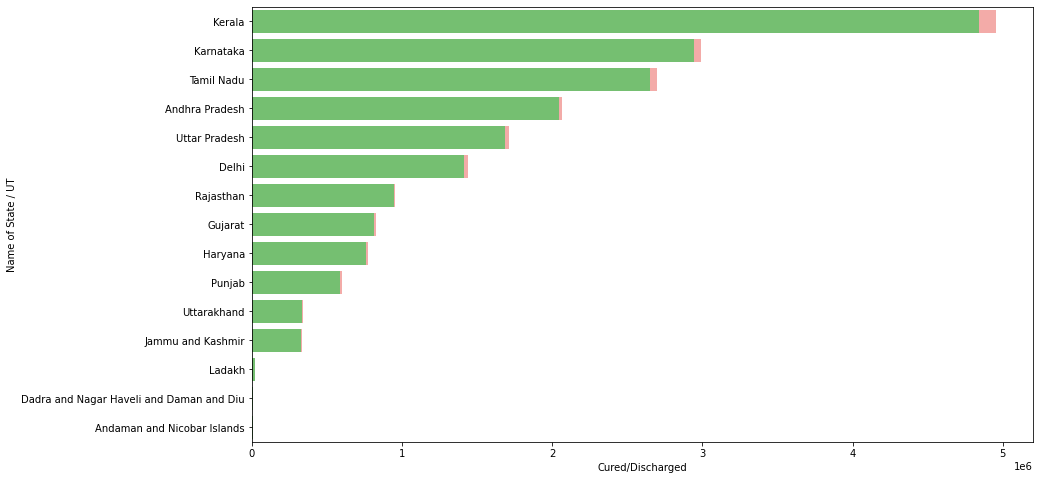

In [ ]:
#@title
## Confirmed vs Recovered Figures
fig, ax = plt.subplots(figsize = (14,8))
data = df_full[['Name of State / UT', 'Confirmed Cases', 'Cured/Discharged', 'Death']]
data.sort_values('Confirmed Cases', ascending = False, inplace = True)
sns.set_color_codes("pastel")
sns.barplot(x = 'Confirmed Cases', y = 'Name of State / UT', data = data, label = 'Total', color = 'r')

sns.set_color_codes('muted')
sns.barplot(x = 'Cured/Discharged', y = 'Name of State / UT', data = data, label = 'Cured', color = 'g')

## Total Number of Deaths Statewise

In [ ]:
#@title
table1 = df_state_tot[['Name of State / UT', 'Death', 'Active Cases']].sort_values(by = 'Death')
table1.head()

,Name of State / UT,Death,Active Cases
4717,Dadra and Nagar Haveli and Daman and Diu,4.0,6.0
11206,Lakshadweep,51.0,0.0
600,Andaman and Nicobar Islands,129.0,5.0
10606,Ladakh,208.0,58.0
1785,Arunachal Pradesh,280.0,108.0


Text(0.5, 1.0, 'Deaths per State')

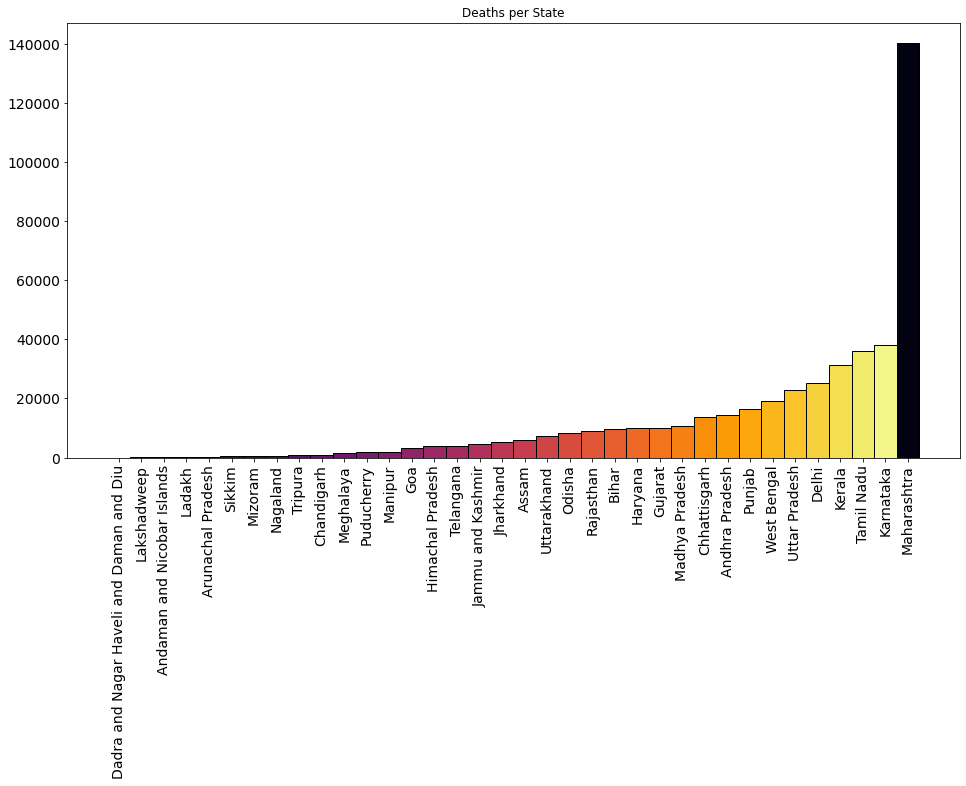

In [ ]:
#@title
plt.subplots(figsize = (16,8))
plt.bar(table1['Name of State / UT'], table1['Death'], width = 1, edgecolor = 'black', color = sns.color_palette('inferno', 35))
plt.xticks(rotation = 90, size = 14)
plt.yticks(size = 14)
plt.title('Deaths per State')

## Total Number of Active Cases Statewise

In [ ]:
#@title
table2 = table1.copy()
table2.sort_values(by = 'Active Cases', inplace = True)
table2.head()

,Name of State / UT,Death,Active Cases
11206,Lakshadweep,51.0,0.0
600,Andaman and Nicobar Islands,129.0,5.0
4717,Dadra and Nagar Haveli and Daman and Diu,4.0,6.0
16918,Rajasthan,8954.0,30.0
3532,Chandigarh,820.0,30.0


Text(0.5, 1.0, 'Deaths per State')

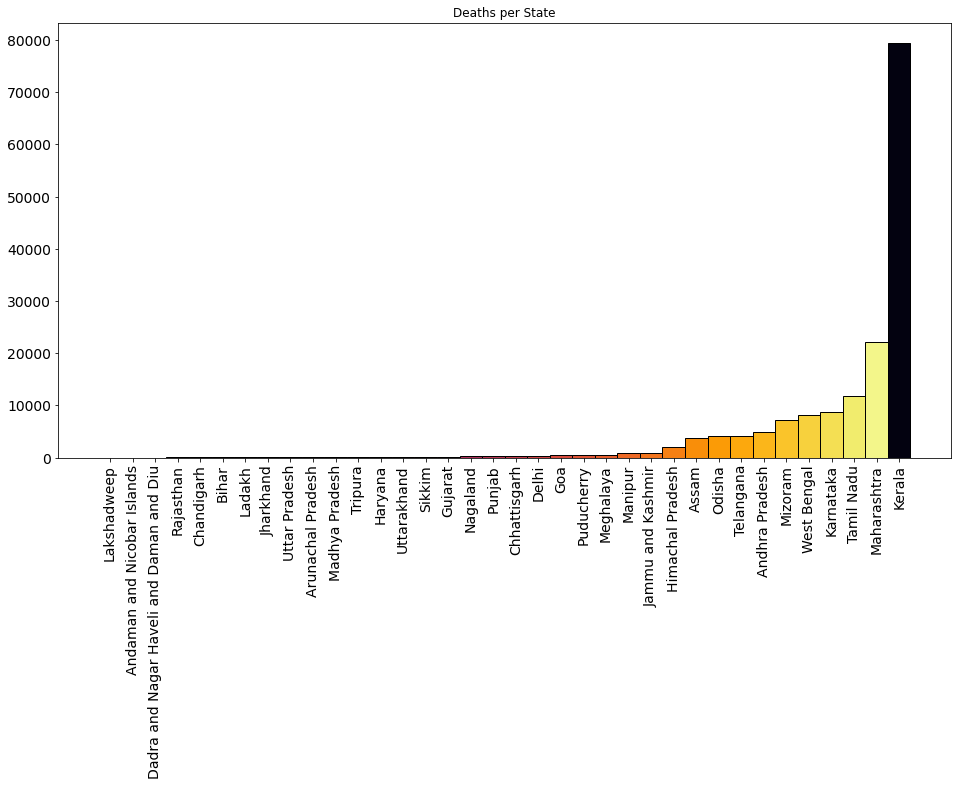

In [ ]:
#@title
plt.subplots(figsize = (16,8))
plt.bar(table2['Name of State / UT'], table2['Active Cases'], width = 1, edgecolor = 'black', color = sns.color_palette('inferno', 35))
plt.xticks(rotation = 90, size = 14)
plt.yticks(size = 14)
plt.title('Deaths per State')

## Rise in Total Deaths Across India

In [ ]:
df_india.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01/01/1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1
1,12/03/2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13/03/2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14/03/2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15/03/2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3


In [ ]:
India_table = df_india[df_india['Date_converted'] != '1970-01-01']
India_table.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
1,12/03/2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13/03/2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14/03/2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15/03/2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3
5,16/03/2020,India,114,99.0,13.0,2.0,2020-03-16,2020,3


In [ ]:
India_table.shape

(599, 9)

In [ ]:
df_india_tot = df_india[df_india['Date_converted'] == '1970-01-01']
df_india_tot.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01/01/1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1


In [ ]:
df_india[df_india['Date_converted'] > '2021-10-01'].shape

(45, 9)

### Creating Data Frame for Delhi

In [ ]:
df_delhi = df_states[df_states['Region'] == 'Delhi']
df_delhi.drop(index = 5259, inplace = True)

In [ ]:
df_delhi.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
5260,12/03/2020,Delhi,6,6.0,0.0,0.0,2020-03-12,2020,3
5261,13/03/2020,Delhi,6,6.0,0.0,0.0,2020-03-13,2020,3
5262,14/03/2020,Delhi,7,5.0,1.0,1.0,2020-03-14,2020,3
5263,15/03/2020,Delhi,7,4.0,2.0,1.0,2020-03-15,2020,3
5264,16/03/2020,Delhi,7,4.0,2.0,1.0,2020-03-16,2020,3


## Using Machine Learning Models to Predict Covid-19 Cases

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# to implement linear regression on a time series the datetime format has to
# be converted to ordinal else code will give an error. I have done this to
# df_delhi dataset and created a new column for the same.
import datetime as dt
df_delhi['Date_for_reg']=df_delhi['Date_converted'].map(dt.datetime.toordinal)
df_delhi.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month,Date_for_reg
5260,12/03/2020,Delhi,6,6.0,0.0,0.0,2020-03-12,2020,3,737496
5261,13/03/2020,Delhi,6,6.0,0.0,0.0,2020-03-13,2020,3,737497
5262,14/03/2020,Delhi,7,5.0,1.0,1.0,2020-03-14,2020,3,737498
5263,15/03/2020,Delhi,7,4.0,2.0,1.0,2020-03-15,2020,3,737499
5264,16/03/2020,Delhi,7,4.0,2.0,1.0,2020-03-16,2020,3,737500


In [ ]:
X = df_delhi['Date_for_reg']
y = df_delhi['Confirmed Cases']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train, y_train = np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1)

In [ ]:
print(X_train.shape, y_train.shape)

(449, 1) (449, 1)


In [ ]:
X_test, y_test = np.array(X_test).reshape(-1,1), np.array(y_test).reshape(-1,1)


In [ ]:
print(X_test.shape, y_test.shape)


(150, 1) (150, 1)


### Linear Regression

In [ ]:
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(X_train, y_train)

LinearRegression(normalize=True)

In [ ]:
prediction_lin_reg = lin_reg.predict(X_test)

In [ ]:
Lr_result = pd.DataFrame(prediction_lin_reg)
Lr_result.head()

,0
0,7.426259e+05
1,1.093336e+05
2,7.365656e+05
3,1.415310e+06
4,6.309945e+03


In [ ]:
mean_squared_error(prediction_lin_reg, y_test)

19187648121.233818

### SVR Algorithm

In [ ]:
# building the SVM model
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01,0.1,1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma': gamma, 'epsilon': epsilon, 'shrinking': shrinking}

In [ ]:
svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv =3, return_train_score=True, n_jobs=1, n_iter = 40, verbose=1)
svm_search.fit(X_train, y_train)

In [ ]:
# svm.search.best_params_

## Time Series Analysis

In [ ]:
df_input = df_delhi[['Date_converted', 'Confirmed Cases']]
df_input.rename(columns = {'Date_converted': 'ds', 'Confirmed Cases': 'y'}, inplace = True)
df_input.reset_index(inplace = True)
df_input.drop(columns = 'index', inplace = True)
df_input.head()

,ds,y
0,2020-03-12,6
1,2020-03-13,6
2,2020-03-14,7
3,2020-03-15,7
4,2020-03-16,7


In [ ]:
df_input[:593].tail()

,ds,y
588,2021-11-06,1440035
589,2021-11-07,1440071
590,2021-11-08,1440118
591,2021-11-09,1440143
592,2021-11-10,1440176


### ARIMA MODEL

### PROPHET MODEL

In [ ]:
from fbprophet import Prophet

### Forecasting Confirmed COVID-19 Cases for Delhi with Prophet (Base Model)

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(df_input[:593])
future = m.make_future_dataframe(periods = 14)
future.tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
597,2021-11-15
598,2021-11-16
599,2021-11-17
600,2021-11-18
601,2021-11-19
602,2021-11-20
603,2021-11-21
604,2021-11-22
605,2021-11-23
606,2021-11-24


In [ ]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
597,2021-11-15,1441093.47580,1425950.87206,1459376.42232
598,2021-11-16,1440800.63430,1424537.03719,1458530.51864
599,2021-11-17,1441023.81761,1423241.39115,1458729.61444
600,2021-11-18,1441310.27868,1422224.31834,1461986.57442
601,2021-11-19,1441226.86513,1418170.31081,1467274.03530
602,2021-11-20,1441534.49323,1412748.11021,1470641.06688
603,2021-11-21,1441581.18394,1411536.89691,1474428.87006
604,2021-11-22,1441439.43436,1409643.05853,1483819.34502
605,2021-11-23,1441146.59286,1402895.70153,1490417.63923
606,2021-11-24,1441369.77617,1398788.97469,1491206.88717


Let us plot the forecast by calling the Prophet.plot method and passing in our forecast dataframe.

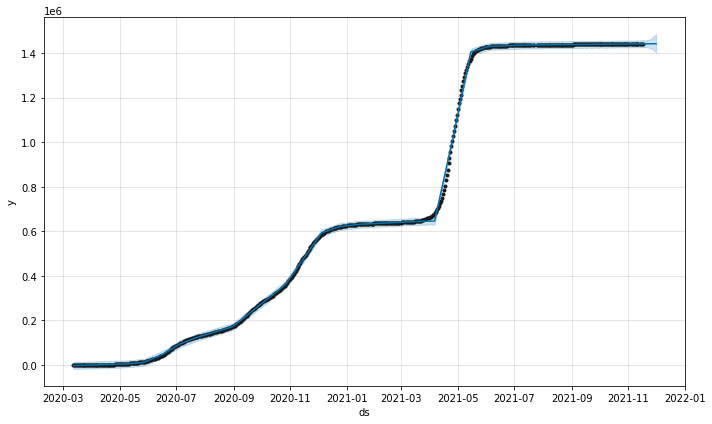

In [ ]:
#@title
confirmed_forecast_plot = m.plot(forecast)

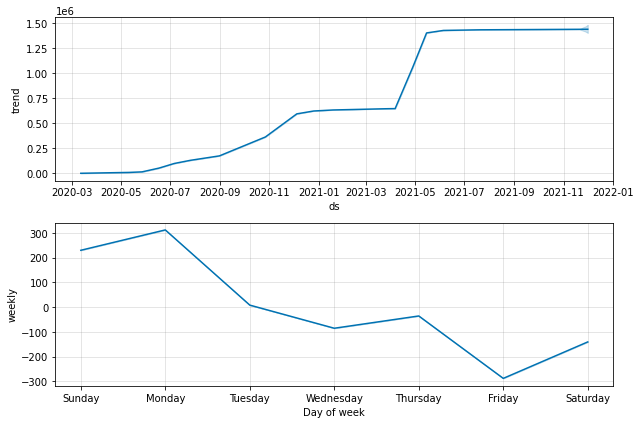

In [ ]:
#@title
confirmed_forecast_plot = m.plot_components(forecast)

### Holts Model For Time Series Prediction

In [ ]:
from statsmodels.tsa.api import Holt

In [ ]:
df_input.head()

,ds,y
0,2020-03-12,6
1,2020-03-13,6
2,2020-03-14,7
3,2020-03-15,7
4,2020-03-16,7


In [ ]:
train_data = df_input.iloc[:int(df_input.shape[0]*0.80)]
test_data = df_input.iloc[int(df_input.shape[0]*0.80):]

In [ ]:
fitted_model = Holt(train_data['y']).fit(smoothing_level=1.4, smoothing_slope=0.2)
test_predictions = fitted_model.forecast(len(test_data))

In [ ]:
test_predictions

479   1435194.59052
480   1435270.89041
481   1435347.19030
482   1435423.49019
483   1435499.79008
           ...     
594   1443969.07781
595   1444045.37770
596   1444121.67759
597   1444197.97748
598   1444274.27737
Length: 120, dtype: float64

In [ ]:
# holt_new_date = []
# holt_new_prediction = []
# for i in range():

SyntaxError: ignored